In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

# load data
import os
import gzip
import copy

In [2]:
# 从本地加载Fashion-MNIST数据集，返回DataLoader
def load_data():

    def load_mnist(path, kind='train'):

        """Load MNIST data from `path`"""
        labels_path = os.path.join(path,
                                   '%s-labels-idx1-ubyte.gz'
                                   % kind)
        images_path = os.path.join(path,
                                   '%s-images-idx3-ubyte.gz'
                                   % kind)

        with gzip.open(labels_path, 'rb') as lbpath:
            labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                                   offset=8)

        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                                   offset=16).reshape(len(labels), 28, 28)

        return images, labels

    X_train, y_train = load_mnist('./data/Fashion', kind='train')
    X_test, y_test = load_mnist('./data/Fashion', kind='t10k')
    
    X_train = copy.deepcopy(X_train)
    y_train = copy.deepcopy(y_train)
    X_test = copy.deepcopy(X_test)
    y_test = copy.deepcopy(y_test)
    
    def expand_x_dims(x):
        new_x = []
        for i in range(len(x)):
            x0 = x[i] / 255
            x0 = np.expand_dims(x0, axis=0)
            new_x.append(x0)
        
        return np.array(new_x)
    
    X_train = expand_x_dims(X_train)
    X_test = expand_x_dims(X_test)
    
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.int64)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.int64)
    
    train_set = TensorDataset(X_train, y_train)
    test_set = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=True)
    
    return train_loader, test_loader

In [3]:
train_loader, test_loader = load_data()

In [4]:
class CNN5(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=18, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=18, out_channels=24, kernel_size=5)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=30, kernel_size=5)
        self.fc1 = nn.Linear(in_features=30*4*4, out_features=160)
        self.fc2 = nn.Linear(in_features=160, out_features=80)
        self.out = nn.Linear(in_features=80, out_features=10)
        
    def forward(self, t):
        # 1st convolutional layer
        t = F.relu(self.conv1(t))
        
        # 2nd convolutional layer
        t = F.relu(self.conv2(t))

        # 3rd convolutional layer
        t = F.relu(self.conv3(t))

        # 4th convolutional layer
        t = F.relu(self.conv4(t))

        # 5th convolutional layer
        t = F.relu(self.conv5(t))
        
        # reshaping
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        t = t.reshape(-1, 30*4*4)
        
        # 1st fully-connected layer
        t = F.relu(self.fc1(t))
        
        # 2nd fully-connected layer
        t = F.relu(self.fc2(t))
        
        # output layer
        t = self.out(t)
        
        return t

In [5]:
# 加载已有模型
net_5 = CNN5()
net_5.load_state_dict(torch.load('./data/CNN5-statedict.pth'))
net_5.eval()

CNN5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 18, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(18, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(24, 30, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=480, out_features=160, bias=True)
  (fc2): Linear(in_features=160, out_features=80, bias=True)
  (out): Linear(in_features=80, out_features=10, bias=True)
)

In [6]:
def feature_visualize(net, net_input, label):
    
    def get_one_conv_layer(net, layer_num, net_input):
        # 1st convolutional layer
        t = F.relu(net.conv1(net_input))
        if layer_num == 1:
            return t, 6
        
        # 2nd convolutional layer
        t = F.relu(net.conv2(t))
        if layer_num == 2:
            return t, 12
        
        # 3rd convolutional layer
        t = F.relu(net.conv3(t))
        if layer_num == 3:
            return t, 18
        
        # 4th convolutional layer
        t = F.relu(net.conv4(t))
        if layer_num == 4:
            return t, 24
        
        # 5th convolutional layer
        t = F.relu(net.conv5(t))
        if layer_num >= 5:
            return t, 30
    
    # extract features
    features = []
    for i in range(5):
        x, length = get_one_conv_layer(net, i+1, net_input)
        x = x.squeeze().detach().numpy()
        feature = np.zeros(x[0].shape)
        for i in range(length):
            feature += x[i]
        feature /= length
        features.append(feature)
    
    # visualization using matplotlib
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize = (18, 3))
    ax[0].imshow(net_input[0][0])
    plt.title(label, fontsize='xx-large', loc='right')
    ax[1].imshow(features[0])
    ax[2].imshow(features[1])
    ax[3].imshow(features[2])
    ax[4].imshow(features[3])
    ax[5].imshow(features[4])
    plt.show()

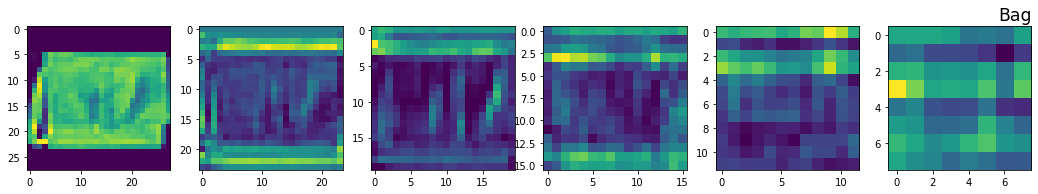

In [7]:
# 从DataLoader中提取并可视化样本
sample_batch = next(iter(train_loader))
images, labels = sample_batch

classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
feature_visualize(net=net_5, net_input=images[0].unsqueeze(0), label=classes[labels[0]])